In [23]:
## caged_brach
%reload_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200

import basedosdados as bd
from geobr import read_municipality, read_state

import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import  OffsetImage
from matplotlib import colors, cm

from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

### Refs

- [google](https://www.google.com.br/search?q=high+school+race+us+map&hl=pt-BR&sxsrf=ALeKk025ryNlkzzMnPWJaybuQMK7sjpvmQ:1620515506596&tbm=isch&source=iu&ictx=1&fir=bA3OQhLFXqPvKM%252CYxgSnNL9hfIniM%252C_&vet=1&usg=AI4_-kQn3AIYsBQCaND7fpfFC7ScH1kFqA&sa=X&ved=2ahUKEwifhv7YmrvwAhU1pZUCHfSBAU4Q9QF6BAgOEAE#imgrc=YirASAz_MsudVM)

- [Vox - 3 maps that show school segregation in the US](https://www.vox.com/xpress/2014/8/28/6078583/3-maps-that-show-how-segregated-americas-schools-are)

- [America is more diverse than ever — but still segregated ](https://www.washingtonpost.com/graphics/2018/national/segregation-us-cities/)


- [Nexo - Onde estão os estudantes de ensino superior no Brasil](https://www.nexojornal.com.br/grafico/2019/05/14/Onde-est%C3%A3o-os-estudantes-de-ensino-superior-no-Brasil)

In [2]:
# query = """
# WITH censo_escola as (
# SELECT *
# FROM `basedosdados-dev.br_inep_censo_escolar.matricula`
# )
# SELECT 
#   ano,
#   sigla_uf,
#   id_municipio,
#   rede,
#   CASE 
#       WHEN sexo = 1 THEN "Masculino"
#       WHEN sexo = 2 THEN "Feminino"
#       WHEN sexo = -1 THEN "Ignorado"
#       WHEN sexo IS NULL THEN "Nao consta"
#   END AS sexo,
#   CASE 
#       WHEN raca_cor = 0 THEN "Nao declarado"
#       WHEN raca_cor = 1 THEN "Branca"
#       WHEN raca_cor = 2 THEN "Preta"
#       WHEN raca_cor = 3 THEN "Parda"
#       WHEN raca_cor = 4 THEN "Amarela"
#       WHEN raca_cor = 5 THEN "Indigena"
#       WHEN raca_cor IS NULL THEN "Nao consta"
#   END as raca_cor,
#   SUM(1) as matriculas
# FROM censo_escola
# GROUP BY 1,2,3,4,5,6
# """

# df = bd.read_sql(query, billing_project_id='basedosdados-dev')
# df.to_parquet('../data/censo_escolar/matriculas_raca_cor.parquet')

In [3]:
matriculas = pd.read_parquet('../data/censo_escolar/matriculas_raca_cor.parquet')

In [4]:
matriculas['raca_cor'].unique()

array(['Indigena', 'Parda', 'Preta', 'Nao declarado', 'Branca', 'Amarela'],
      dtype=object)

In [5]:
replace_raca_cor = {
    "Parda": "Preto",
    "Indigena": "Preto",
    "Preta": "Preto",
    "Branca": "Branco",
    "Amarela": "Branco",
    "Nao declarado":"Nao declarado"
}

matriculas["raca_cor"] = (
    matriculas["raca_cor"]
    .map(replace_raca_cor)

)

In [7]:
### Area Plot
matriculas_rede = (
    matriculas[["ano", "rede", "raca_cor", "matriculas"]]
    .groupby(by=["ano", "rede", "raca_cor"])
    .sum()
)
matriculas_rede = (
    matriculas_rede.groupby(level=["ano", "rede"])
    .apply(lambda x: 100 * x / float(x.sum()))
    .reset_index()
)
matriculas_rede["rede"] = np.where(
    matriculas_rede["rede"] == "privada", "privada", "publica"
)



In [8]:
matriculas_2020 = matriculas[matriculas["ano"] == 2020]
matriculas_2020["rede"] = np.where(
    matriculas_2020["rede"] == "privada", "privada", "publica"
)

matriculas_2020 = (
    matriculas_2020
    .groupby(by=["id_municipio", "rede", "raca_cor"])
    .sum()
    .drop("ano", 1)
)
matriculas_municipio = (
    matriculas_2020.groupby(level=["id_municipio", "rede"])
    .apply(lambda x: 100 * x / float(x.sum()))
    .reset_index()
)

mask_publico = (matriculas_municipio["rede"] == "publica")  ## & (matriculas_municipio["raca_cor"] != "Nao declarado")

publico = (
    matriculas_municipio[mask_publico]
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)

mask_privado = (matriculas_municipio["rede"] == "privada") ## & (matriculas_municipio["raca_cor"] != "Nao declarado")

privado = (
    matriculas_municipio[mask_privado]
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)


mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)

df_publico = pd.merge(publico,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_publico = gpd.GeoDataFrame(df_publico)

cols = ['id_municipio','name_muni','rede','raca_cor','matriculas','geometry']
df_publico = df_publico[cols]

df_privado = pd.merge(privado,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_privado = gpd.GeoDataFrame(df_privado)

df_privado = df_privado[cols]


### Area Plot

In [9]:
palete = {
#     'amarelo':"#F5E663",
    'azul':"#3690C0",
#     'verde':"#3F784C",
    'vermelho':"#e64e4e",
    'roxo':"#9970AB",
#     'preto':'#262626'
}


palete = {
#     'amarelo':"#fee391",
    'azul':"#6baed6",
#     'verde':"#31a354",
    'vermelho':"#fb6a4a",
    'roxo':"#756bb1",
#     'preto':'#636363'
}

In [10]:
df_privado['raca_cor'].unique()

array(['Branco', 'Preto', 'Nao declarado', nan], dtype=object)

In [391]:
def plot_bar(matriculas_rede, selected_rede):

    rede = matriculas_rede[matriculas_rede["rede"] == selected_rede]
    rede = (
        rede.pivot_table(columns="raca_cor", index=["ano"], values="matriculas")
        .reset_index()
        .sort_values(by="ano", ascending=False)
    )
    px = 1/plt.rcParams['figure.dpi']
    fig = plt.figure(figsize=((590+15)*px, (640+35)*px))
    ax = plt.subplot()

    bar_colors = [
        palete["roxo"],
        palete["azul"],
        palete["vermelho"],
    ]

    cols_order = [
        "ano",
        "Nao declarado",
        "Branco",
        "Preto",
    ]

    rede[cols_order].plot.barh(
        x="ano",
        stacked=True,
        width=0.953,
        ax=ax,
        color=bar_colors,
        edgecolor="black",
        linewidth=1,
        legend=None

    )

#     ax.set_title(f"Rede {selected_rede}", fontsize=32, pad=0, fontweight="bold")
    ax.set_xlabel("", fontsize=22)
    ax.set_ylabel("", fontsize=22)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.margins(x=0, y=0)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False,labelleft=False, direction='inout') 

    ax.axes.get_xaxis().set_visible(False)
#     ax.axes.get_yaxis().set_visible(False)


#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1], fontsize=25)
    plt.savefig(f'../images/inep_matriculas/bar_{selected_rede}.png', dpi=88,transparent=True, bbox_inches = 'tight', pad_inches = 0)

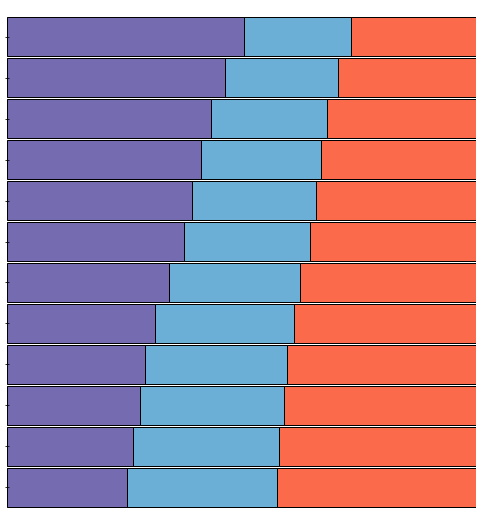

In [392]:
plot_bar(matriculas_rede,'publica')

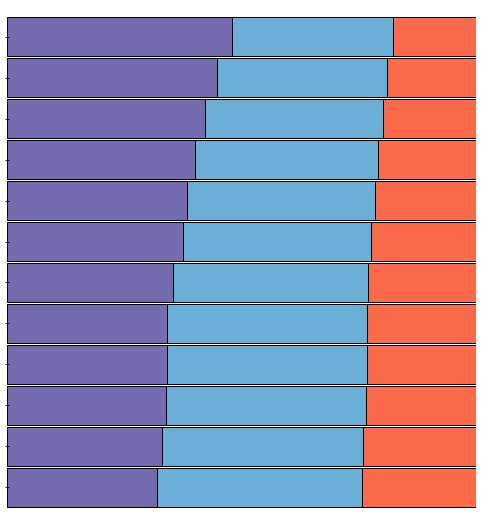

In [393]:
plot_bar(matriculas_rede,'privada')

### Map Plot

1.0847457627118644

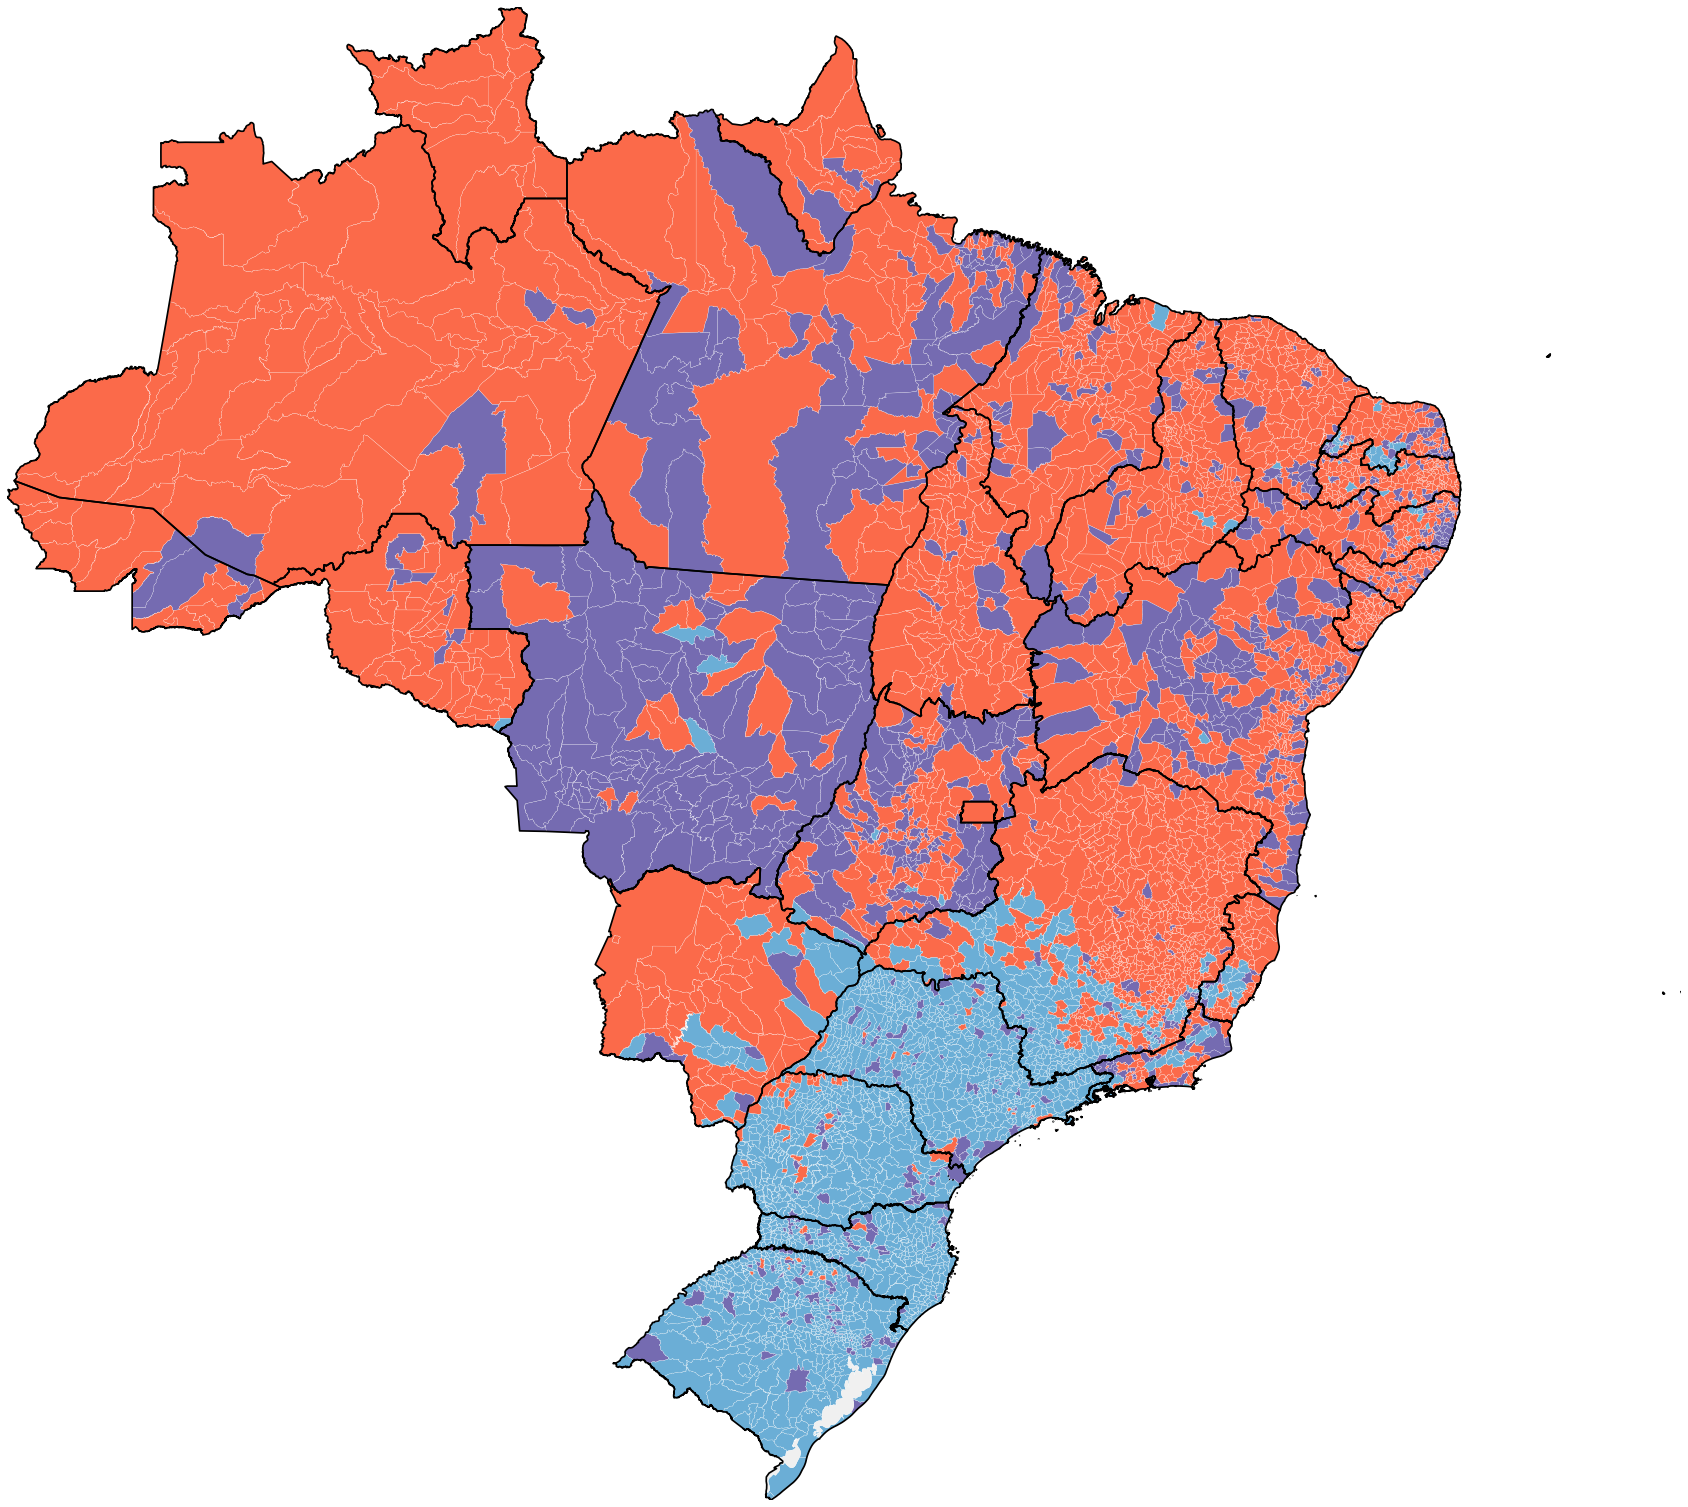

In [409]:
fig = plt.figure(figsize=(30,30 * 640/590))
ax1 = plt.subplot()

colors = [
    palete['azul'],
    palete['roxo'],
    palete['vermelho'],
]

missing_kwds = {
        "color": "#f0f0f0",
        "edgecolor": "#FFFFFF",
#         "hatch": "/",
        "label": "Sem dados",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

df_publico.plot(column='raca_cor',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
        missing_kwds=missing_kwds,
        edgecolor='#FFFFFF',
        linewidth = 0.2,
#         legend=True
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.7, ax=ax1)
# ax1.set_title('Rede publica', fontsize=35,fontweight='bold')

ax1.axis('off')
ax1.margins(x=0, y=0)
plt.savefig('../images/inep_matriculas/mapa_publica.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

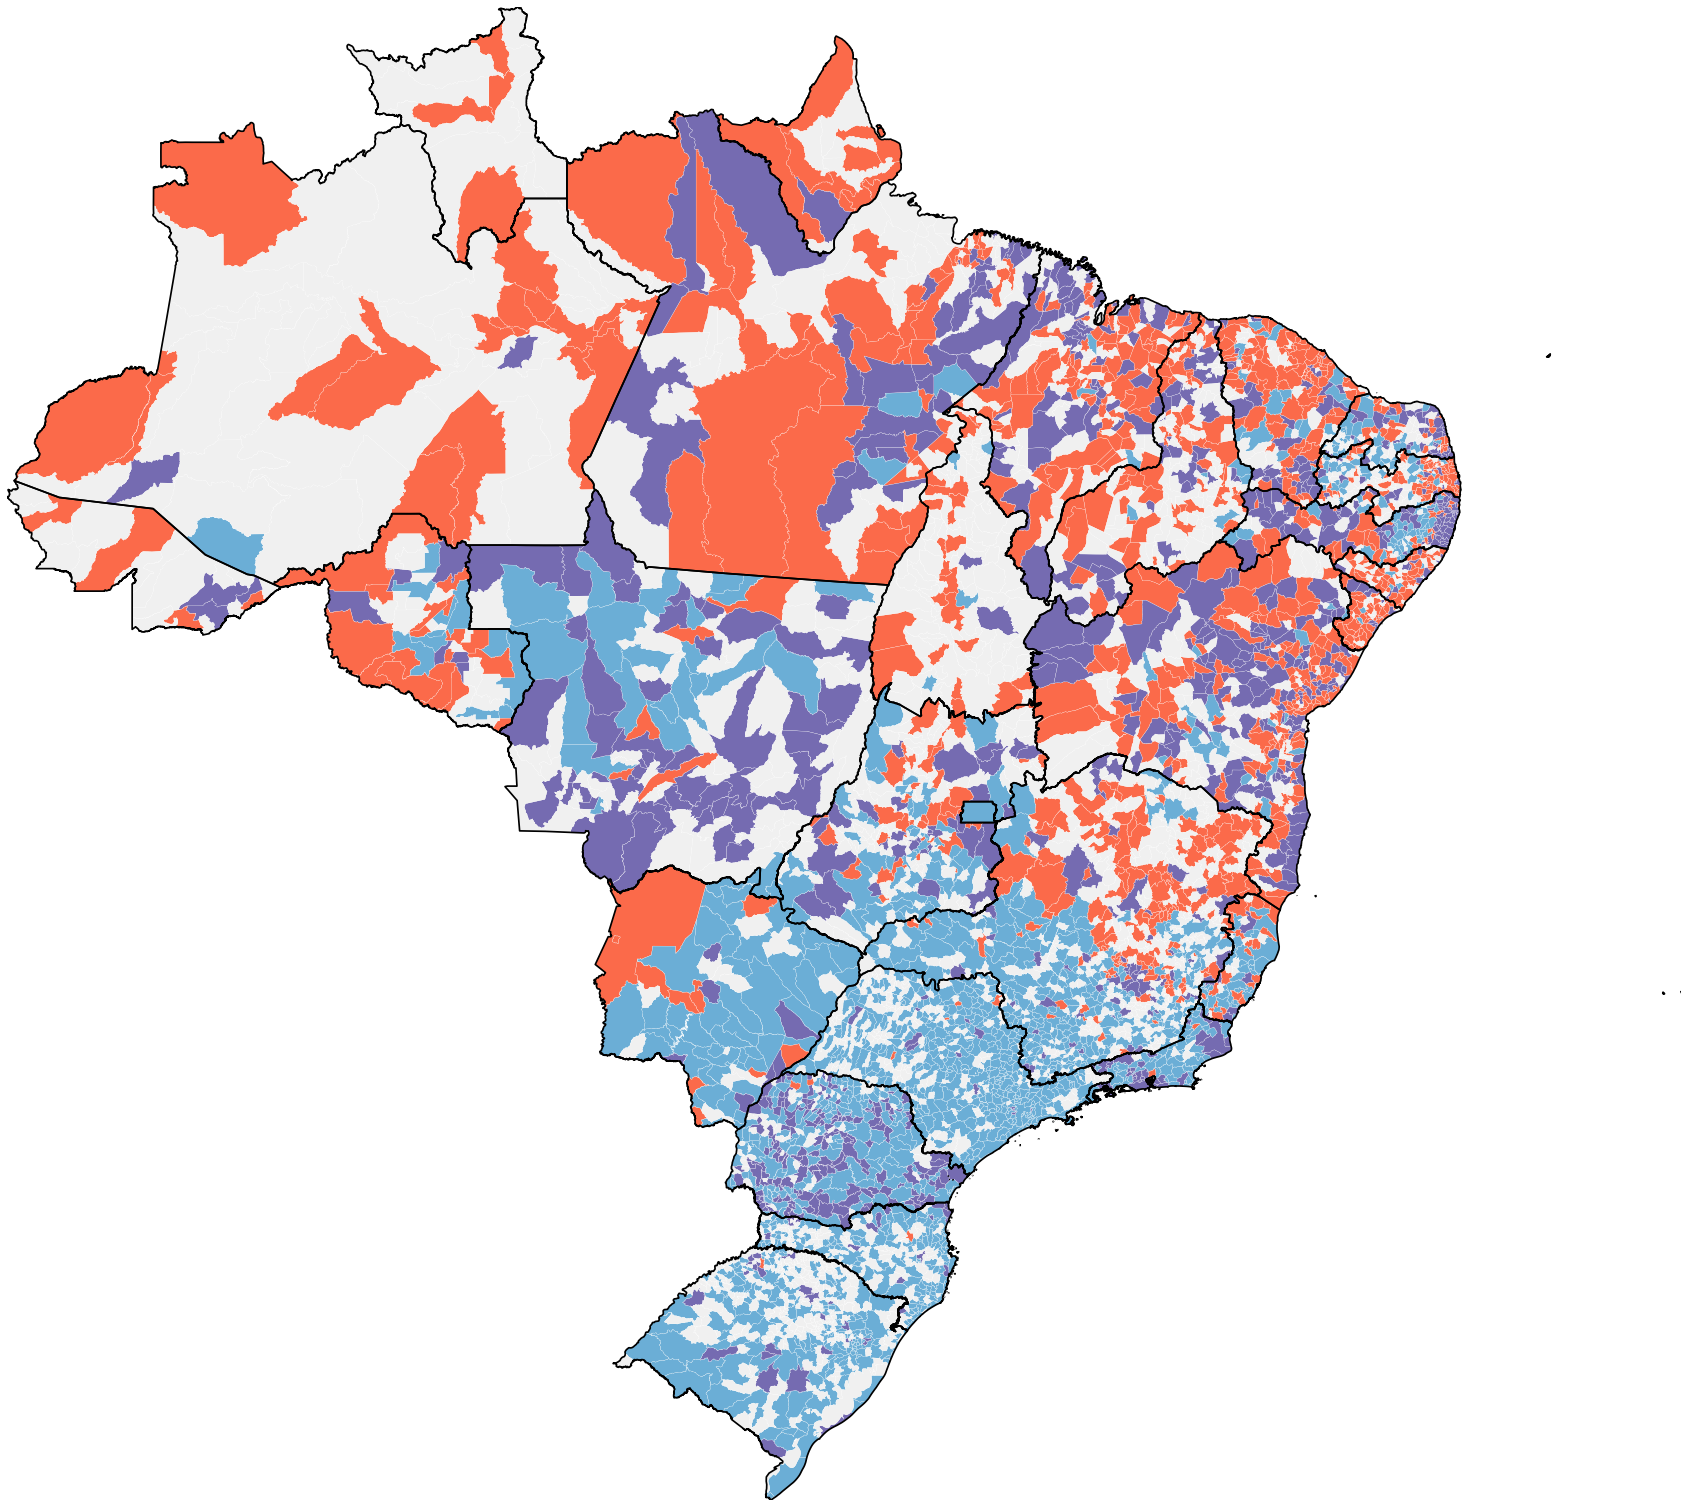

In [410]:
fig = plt.figure(figsize=(30,30 * 640/590))
ax1 = plt.subplot()

colors = [
    palete['azul'],
    palete['roxo'],
    palete['vermelho'],
]

missing_kwds = {
        "color": "#f0f0f0",
        "edgecolor": "#FFFFFF",
#         "hatch": "/",
        "label": "Sem dados",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

df_privado.plot(column='raca_cor',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
        missing_kwds=missing_kwds,
        edgecolor='#FFFFFF',
        linewidth = 0.2,
#         legend=True
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.7, ax=ax1)
# ax1.set_title('Rede privada', fontsize=35,fontweight='bold')

ax1.axis('off')
ax1.margins(x=0, y=0)
plt.savefig('../images/inep_matriculas/mapa_privada.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

### Continuos

In [83]:
mask_publico = (matriculas_municipio["rede"] == "publica") & (
    matriculas_municipio["raca_cor"] != "Nao declarado"
)

publico_c = matriculas_municipio[mask_publico]

publico_c = (
    publico_c
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)    


mask_privado= (matriculas_municipio["rede"] == "privada") & (
    matriculas_municipio["raca_cor"] != "Nao declarado"
)

privado_c = matriculas_municipio[mask_privado]
privado_c = (
    privado_c
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)    


In [85]:
mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)

df_publico_c = pd.merge(publico_c,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_publico_c = gpd.GeoDataFrame(df_publico_c)

cols = ['id_municipio','name_muni','rede','raca_cor','matriculas','geometry']
df_publico_c = df_publico_c[cols]

df_privado_c = pd.merge(privado_c,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_privado_c = gpd.GeoDataFrame(df_privado_c)

cols = ['id_municipio','name_muni','rede','raca_cor','matriculas','geometry']
df_privado_c = df_privado_c[cols]


In [426]:
def plot_continuos_map(df_publico, rede_selected,palette):
    var='matriculas'
    branco = df_publico[df_publico['raca_cor']=='Branco']
    preto = df_publico[df_publico['raca_cor']=='Preto']
    
    no_data_list = branco['id_municipio'].unique().tolist() + preto['id_municipio'].unique().tolist()
    mask = np.logical_not(df_publico['id_municipio'].isin(no_data_list))
    no_data = df_publico[mask]
    
    fig = plt.figure(figsize=(30,30 * 640/590))
    ax = plt.subplot()
    
    bins = [50,60,70,80,90]
    
    cmap = ListedColormap(palette[:6][::-1])

    missing_kwds = {
            "color": "#f0f0f0",
            "edgecolor": "#FFFFFF",
            "label": "Sem dados",
        }

    preto.plot(column=var,
                ax=ax,
    #             legend=True,
    #             legend_kwds = legend_kwds,
                cmap=cmap,
                missing_kwds=missing_kwds,
                scheme='user_defined', 
                classification_kwds={'bins':bins},
                edgecolor='#FFFFFF',
                linewidth = 0.1
           )

    cmap = ListedColormap(palette[6:])
    branco.plot(column=var,
                ax=ax,
    #             legend=True,
    #             legend_kwds = legend_kwds,
                cmap=cmap,
                missing_kwds=missing_kwds,
                scheme='user_defined', 
                classification_kwds={'bins':bins},
                edgecolor='#FFFFFF',
                linewidth = 0.1
    )
    
    no_data.plot(column=var,
                ax=ax,
                missing_kwds=missing_kwds,
    )
    
    
    states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.7, ax=ax)

#     cmap = ListedColormap(palette)
#     colorscale = cmap
#     divider = make_axes_locatable(ax)
#     ax_cb = divider.new_vertical(size="1%", pad=0.5, axes_class=plt.Axes)
#     vmax = df_publico[var].values.max()
#     vmin = df_publico[var].values.min()
#     norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
#     mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
#     fig.add_axes(ax_cb)
#     # labels = [-0.085,-0.050, -0.015,0.015,0.05,0.085]
#     cbar = fig.colorbar(mappable, cax=ax_cb,orientation='horizontal')
#     cbar.ax.set_xticklabels([])
#     cbar.ax.tick_params(labelsize=28) 

#     ax.set_title(f'Rede {rede_selected}', fontsize=35,fontweight='bold', pad=100)


    ax.axis('off')
    ax.margins(x=0, y=0)
    plt.savefig(f'../images/inep_matriculas/mapa_cont_{rede_selected}.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

In [427]:
['#99000d', '#cb181d', '#ef3b2c', '#fb6a4a', '#fc9272', '#fcbba1'][::-1]

['#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#99000d']

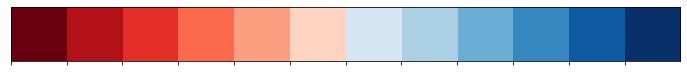

In [428]:

colors_preto = ['#67000C', '#B11117', '#E32F27', '#FB6A4A', '#FC9F81', '#FDD4C2']
colors_branco = ['#D6E5F4','#ABCFE5','#6AADD5','#3787C0','#0F5BA3','#08306B']

palette = colors_preto + colors_branco
sns.palplot(palette)    

In [429]:

# palette = list(sns.diverging_palette(12, 263, n=10, s=100, l=36).as_hex())
# sns.palplot(palette)
# palette

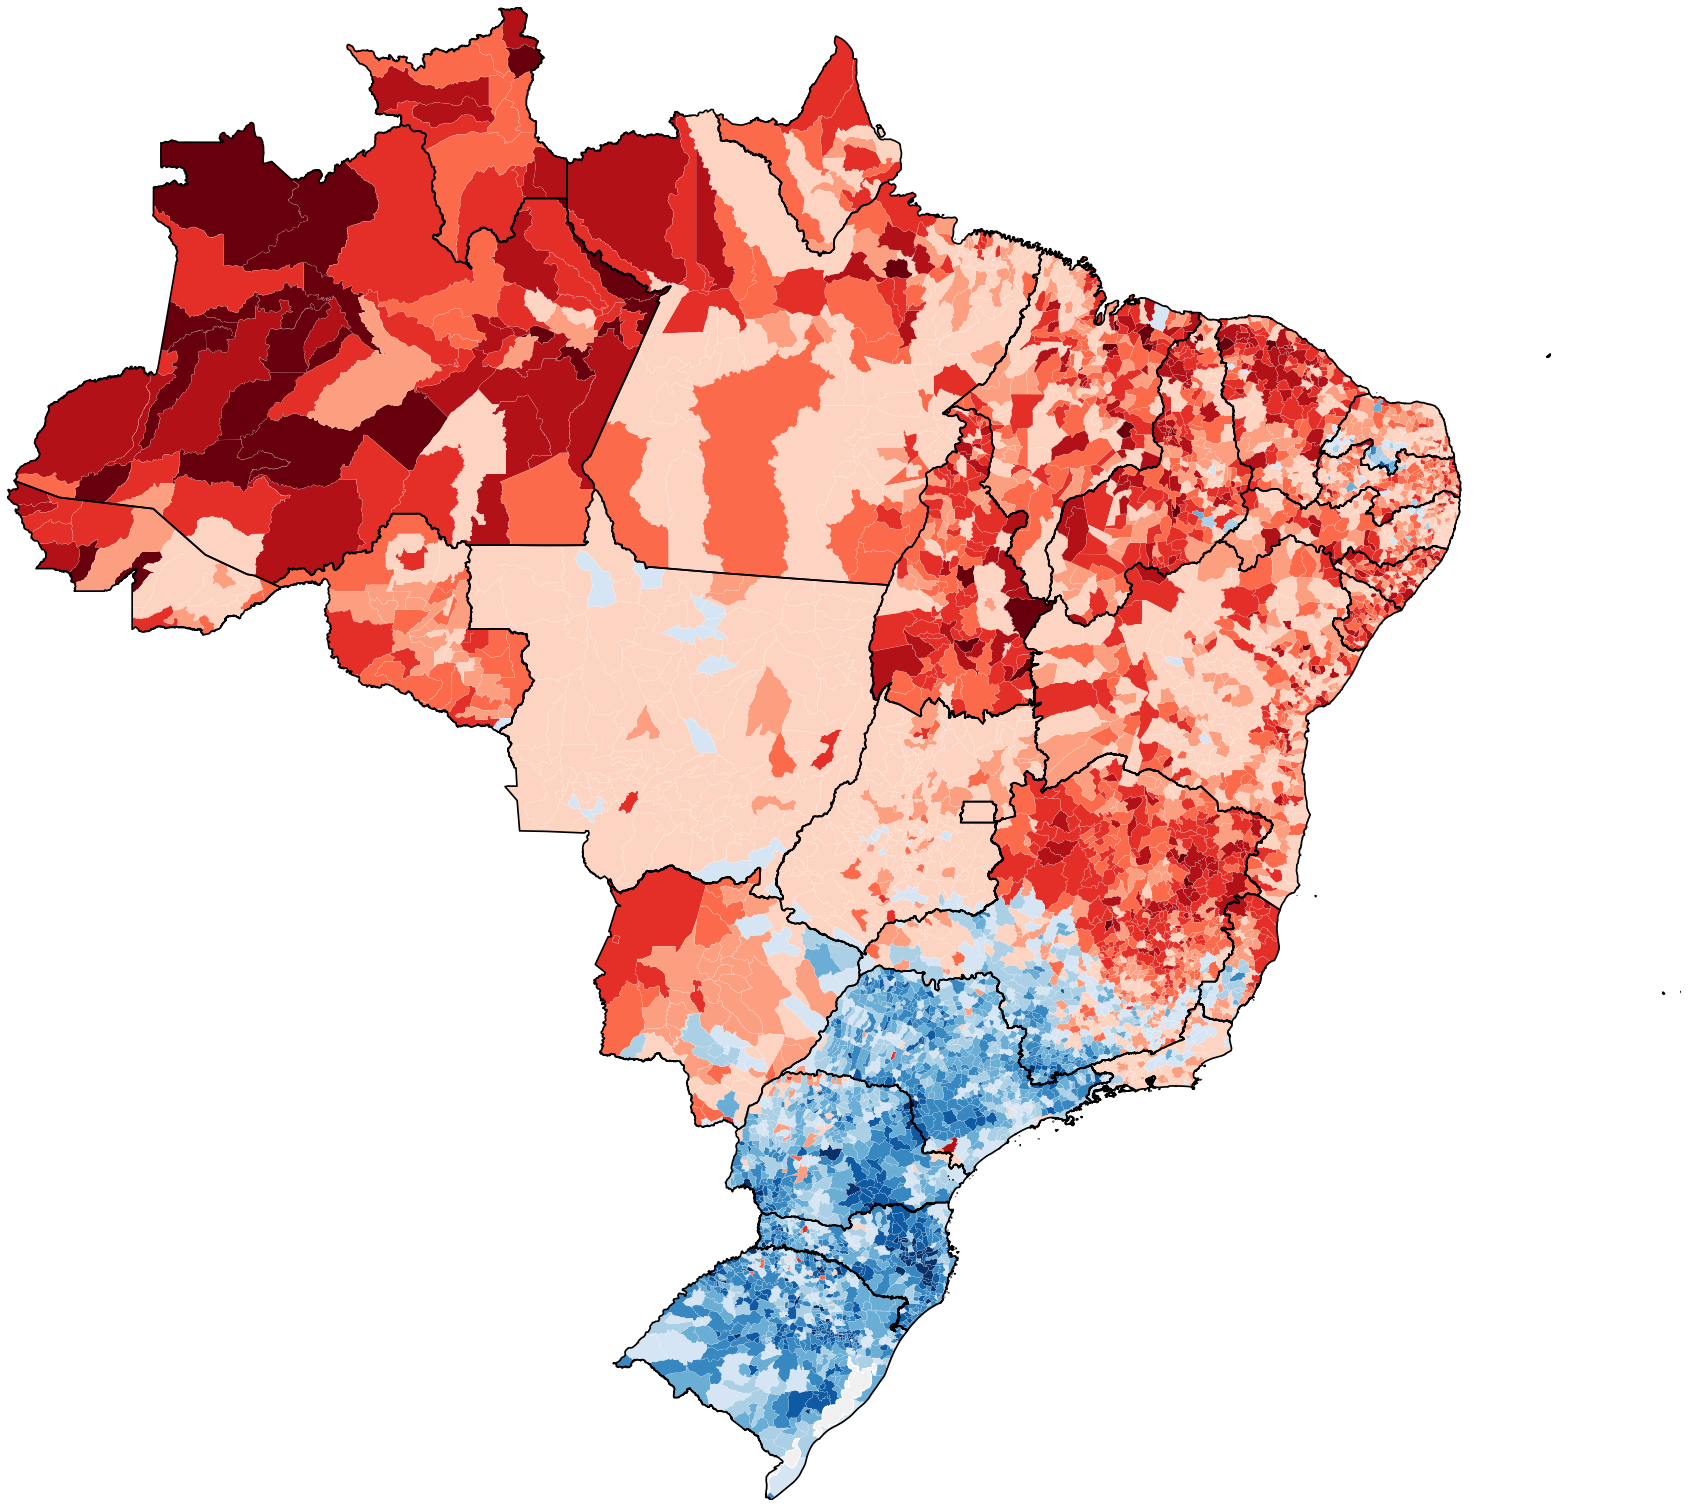

In [430]:
plot_continuos_map(df_publico_c, 'publico',palette)

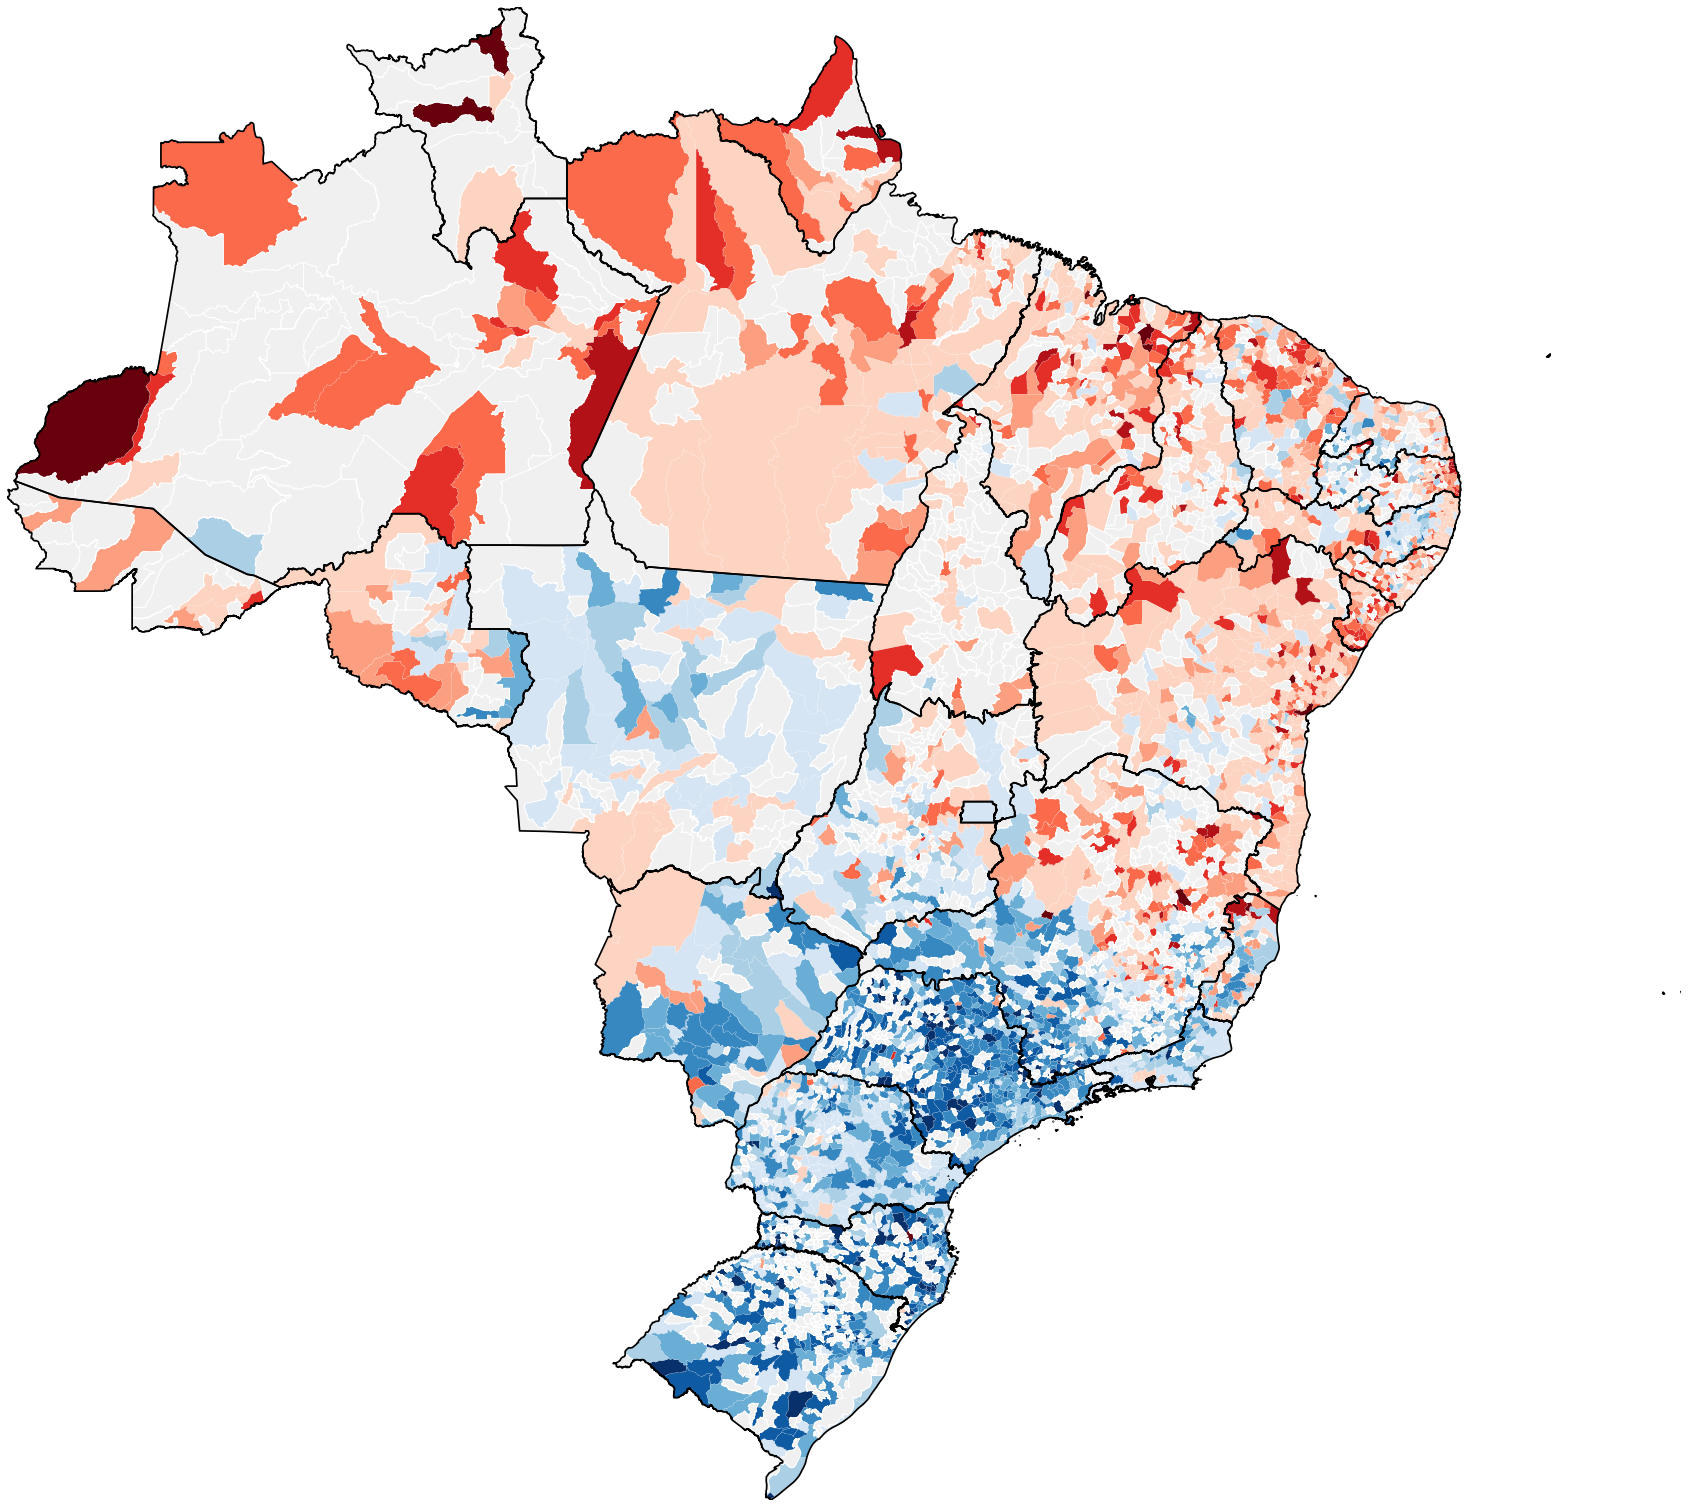

In [431]:
plot_continuos_map(df_privado_c, 'privada',palette)

In [13]:
def plot_rede(matriculas_rede, selected_rede):
    rede = matriculas_rede[matriculas_rede["rede"] == selected_rede]
    rede = rede.pivot_table(
        columns="raca_cor", index=["ano"], values="matriculas"
    ).reset_index()

    fig = plt.figure(figsize=(25, 15))
    ax = plt.subplot()
    px_area_colors = [
        palete['roxo'],
        palete['azul'],
        palete['vermelho'],
#         palete['preto'],
#         palete['amarelo'],
#         palete['verde'],

    ]
    
    cols_order = [
        "ano",
        "Nao declarado",
        "Branco",
        "Preto",
    ]
    rede[cols_order].plot.area(
        x="ano",
        color=px_area_colors,
        ax=ax,
        legend=True,
    )

    ax.set_title(f"Rede {selected_rede}", fontsize=32, pad=0, fontweight="bold")

    ax.set_xlabel("", fontsize=22)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.margins(x=0, y=0)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=25)

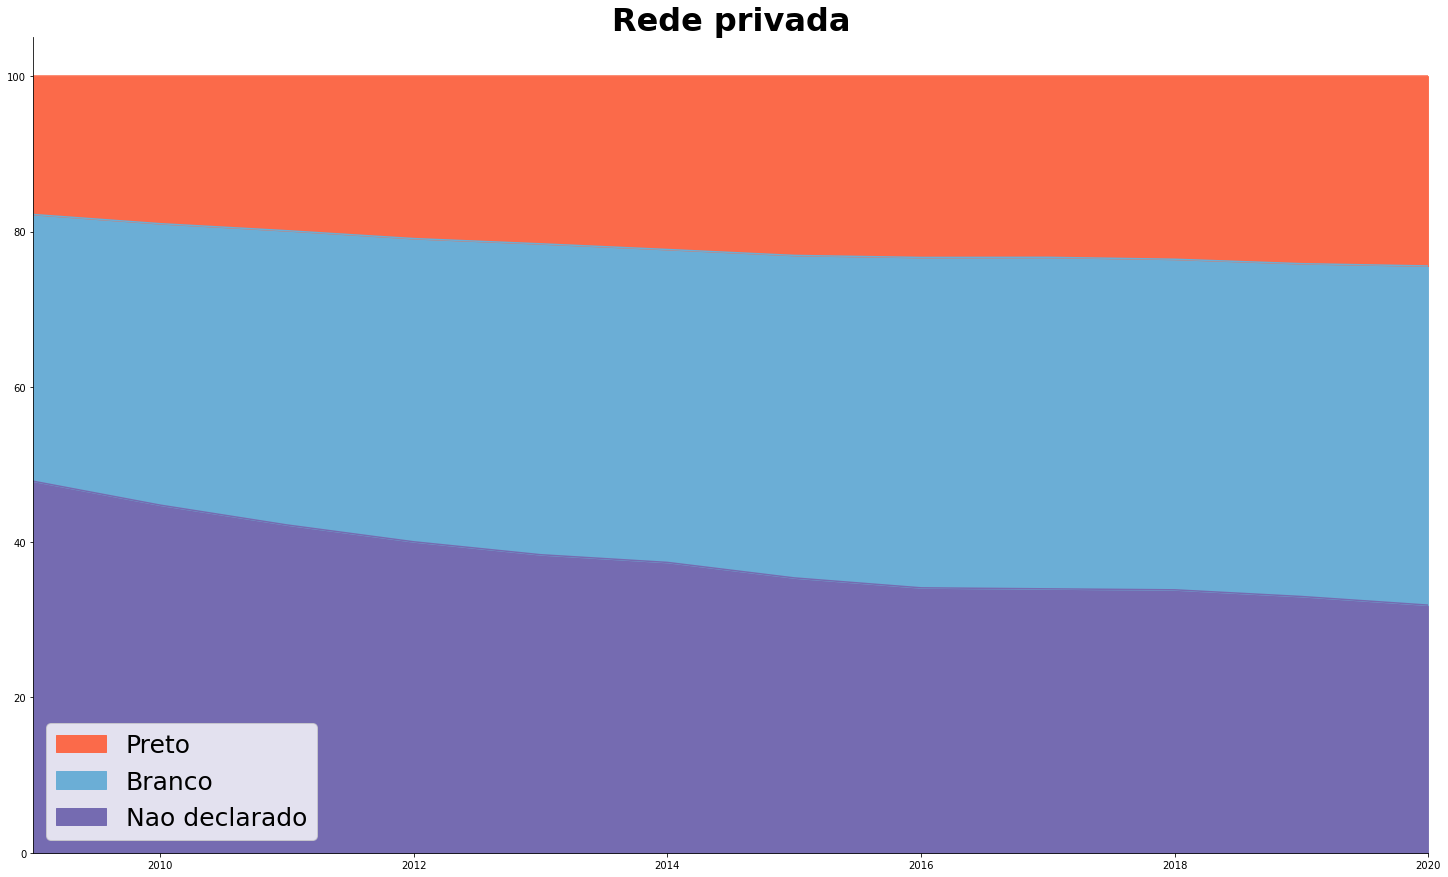

In [14]:
plot_rede(matriculas_rede, 'privada')

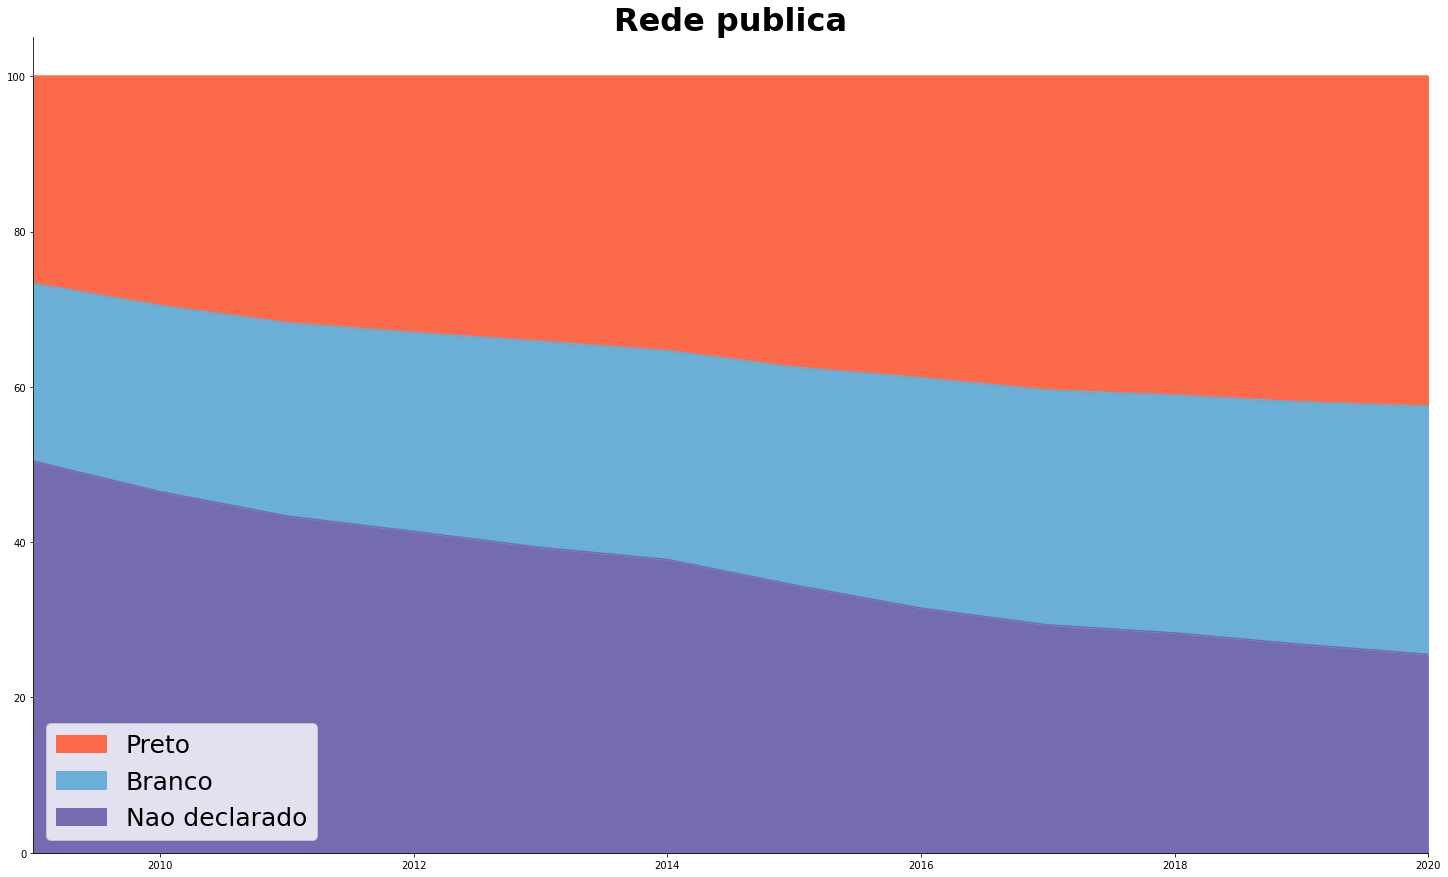

In [15]:
plot_rede(matriculas_rede, 'publica')